## Experiment DL learning with custom embedding and simple Dense layer
Even if the training set is too small to produce a representative word embedding, this notebook illustrates an experiment to have a rough idea on the resulting score with such embedding choice

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from utils import vizu

In [2]:
from sklearn.model_selection import train_test_split

XTrain = pd.read_csv('../../data/staging_data/mispelling_fixed_clean_input_train.csv', sep=',')
YTrain = pd.read_csv('../../data/POSOS/label.csv', sep=';')
XTrain, XTest, YTrain, YTest = train_test_split(XTrain, YTrain, test_size=0.15, random_state=42)

In [3]:
# hyper params
num_classes = 51
patience=20
vocabulary_size = 10000
sequence_length = 30
hidden_dims = 100
embedding_out_dims = 300
dropout_rate=0.2
num_epochs= 100

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(XTrain['question'])

sequences = tokenizer.texts_to_sequences(XTrain['question'])
XEncodedTrain = pad_sequences(sequences, maxlen=sequence_length)

d:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Build the neural network
The NN is composed of 3 layers:
* custom embeddding layer
* fully connected layer to learn classification with relu activation
* decision layer with sotfmax activation

In [5]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation, Flatten
from keras.layers.embeddings import Embedding

import tensorflow as tf
#config = tf.ConfigProto(device_count={"CPU": 32})
config = tf.ConfigProto()
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

model = Sequential()
model.add(Embedding(vocabulary_size , embedding_out_dims, input_length=sequence_length))
model.add(Flatten())
model.add(Dense(hidden_dims, activation='relu'))
model.add(Dropout(rate=dropout_rate))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 300)           3000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 9000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               900100    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 51)                5151      
Total params: 3,905,251
Trainable params: 3,905,251
Non-trainable params: 0
_________________________________________________________________


### Train the network

In [6]:
YOneHotEncodedTrain = keras.utils.to_categorical(YTrain['intention'])

In [8]:
import keras.utils

call_back_board = keras.callbacks.TensorBoard(
    log_dir='c:/git/CES/logs',
    histogram_freq=0,
    batch_size=32,
    write_graph=True,
    write_grads=True,
    write_images=True,
    embeddings_freq=0,
    embeddings_layer_names=None,
    embeddings_metadata=None,
    embeddings_data=None)

# stop criterion to avoid overfitting
call_back_early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=patience,
    verbose=0,
    mode='auto',
    baseline=None)

model.fit(
    XEncodedTrain,
    np.array(YOneHotEncodedTrain),
    validation_split=0.1,
    epochs=num_epochs,
    callbacks = [call_back_early_stopping])
    #callbacks = [call_back_early_stopping, call_back_board])    

Train on 6140 samples, validate on 683 samples
Epoch 1/100
6140/6140 [==============================] - 2s 403us/step - loss: 3.0019 - acc: 0.2704 - val_loss: 2.5965 - val_acc: 0.3792
Epoch 2/100
6140/6140 [==============================] - 2s 336us/step - loss: 1.8773 - acc: 0.5397 - val_loss: 2.0231 - val_acc: 0.5198
Epoch 3/100
6140/6140 [==============================] - 2s 335us/step - loss: 0.8916 - acc: 0.7879 - val_loss: 1.7766 - val_acc: 0.5637
Epoch 4/100
6140/6140 [==============================] - 2s 336us/step - loss: 0.3756 - acc: 0.9186 - val_loss: 1.8191 - val_acc: 0.5622
Epoch 5/100
6140/6140 [==============================] - 2s 335us/step - loss: 0.1753 - acc: 0.9669 - val_loss: 1.8894 - val_acc: 0.5666
Epoch 6/100
6140/6140 [==============================] - 2s 333us/step - loss: 0.0999 - acc: 0.9842 - val_loss: 1.9709 - val_acc: 0.5681
Epoch 7/100
6140/6140 [==============================] - 2s 333us/step - loss: 0.0672 - acc: 0.9906 - val_loss: 2.0451 - val_acc: 0

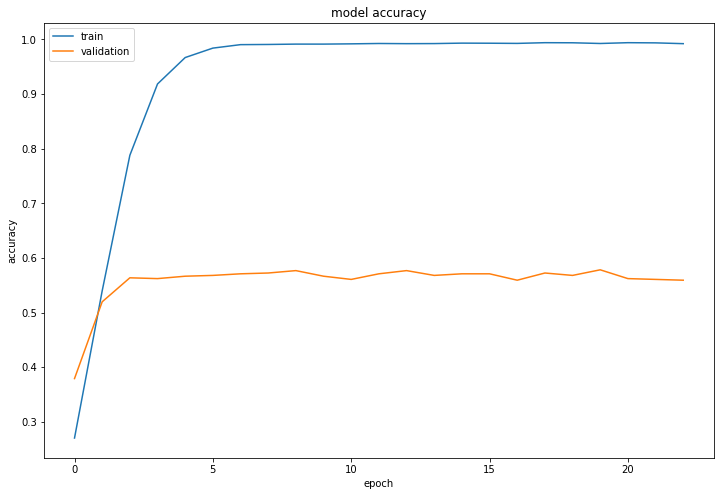

In [9]:
%matplotlib inline
vizu.plot_keras_model_learning_curve(model.history)

d:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.80      0.34      0.48        35
          1       0.00      0.00      0.00         4
          2       0.50      0.20      0.29         5
          3       0.00      0.00      0.00         1
          4       0.75      0.55      0.63        11
          5       0.60      0.17      0.26        18
          6       0.67      0.50      0.57         4
          7       0.00      0.00      0.00         1
          8       0.86      0.48      0.62        25
          9       0.29      0.29      0.29         7
         10       0.83      0.42      0.56        12
         11       0.33      0.26      0.29        27
         12       0.12      0.17      0.14         6
         13       0.44      0.33      0.38        12
         14       0.48      0.57      0.52        42
         15       1.00      0.25      0.40         4
         16       0.50      0.33      0.40         3
         17       1.00      0.50      0.67   

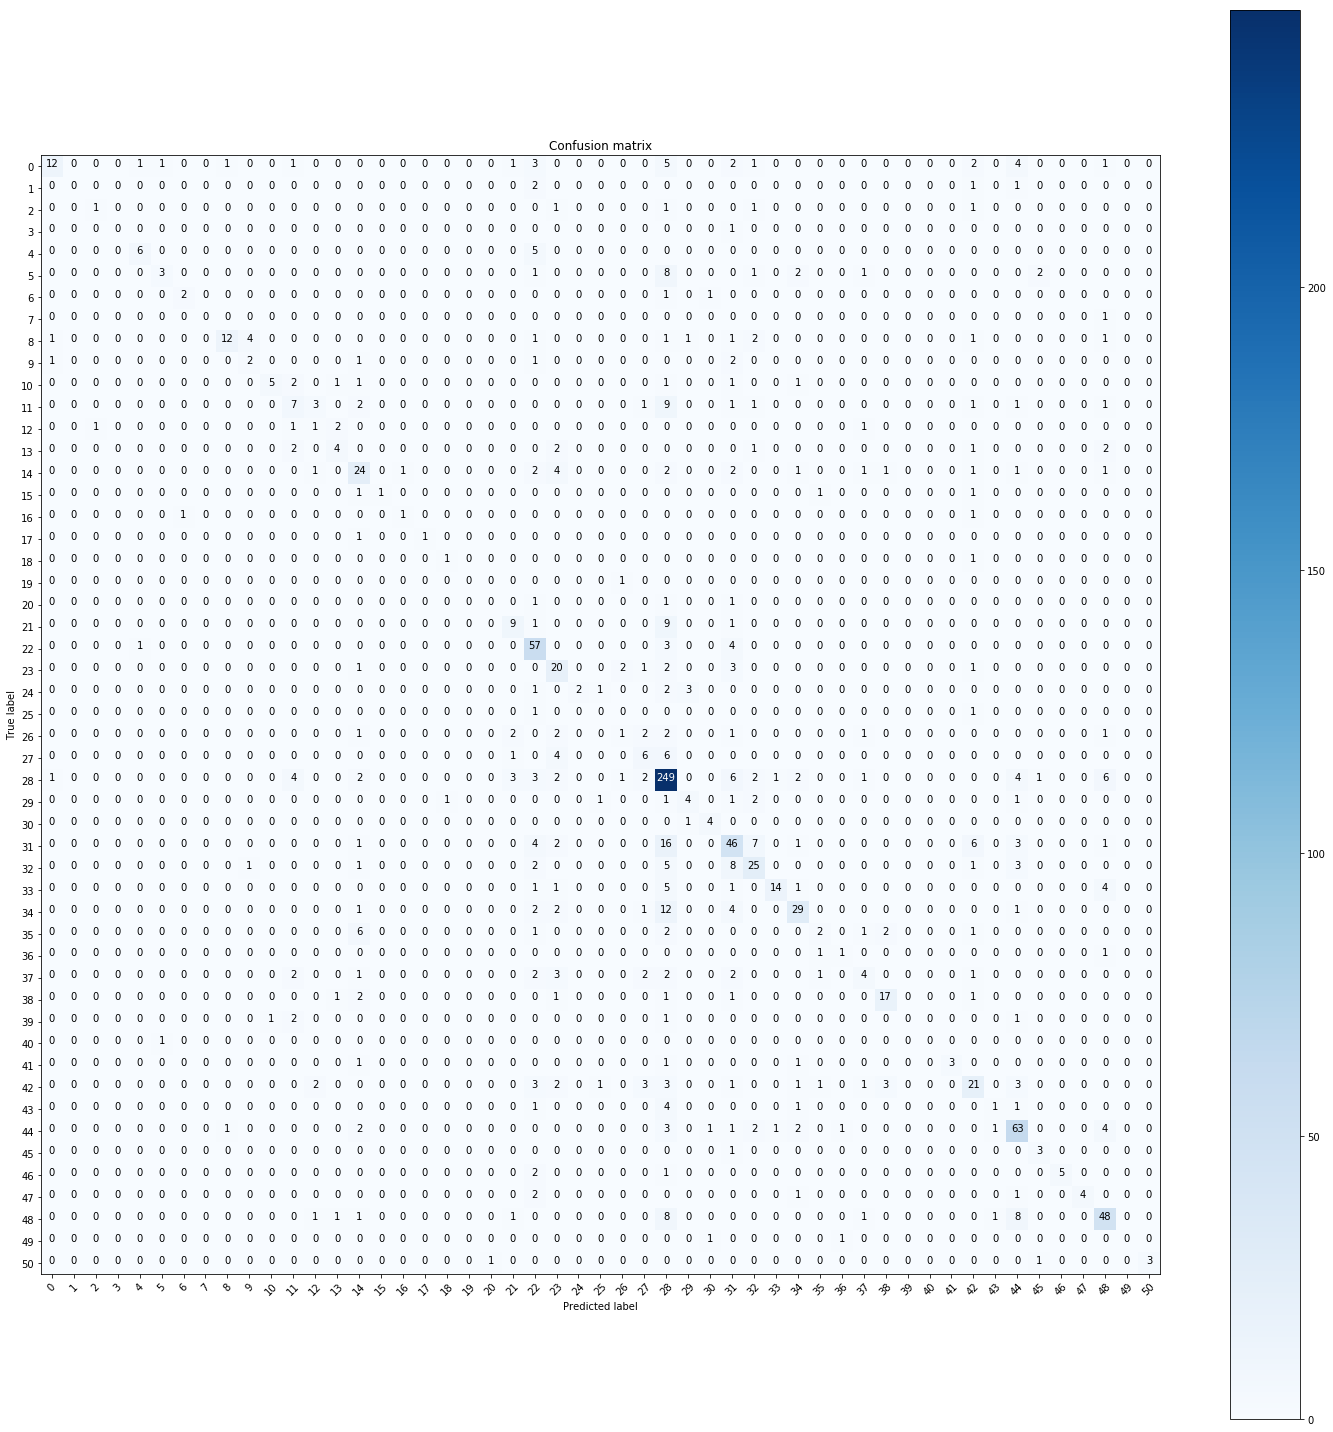

In [10]:
import sklearn
from sklearn.metrics import confusion_matrix

testSequences = tokenizer.texts_to_sequences(XTest['question'])
XEncodedTest = pad_sequences(testSequences, maxlen=sequence_length)
    
YTrue = YTest['intention']
YPredicted = model.predict_classes(XEncodedTest)
#YPredicted =list(map(lambda x : getHighProbaLabel(x), YProba))

cnf_matrix = confusion_matrix(YTrue, YPredicted)

print(sklearn.metrics.classification_report(YTrue, YPredicted))

plt.figure(figsize=(20,20))

vizu.plot_confusion_matrix(cnf_matrix, normalize=False, classes = np.unique(YTrain['intention']))

plt.show()


The model is overfitting rapidly beyond 5 epochs but no observed accuracy improvement on validation set (get rapidly stationary accuracy aounrd 62%)

In [12]:
macroF1Score = sklearn.metrics.f1_score(YTrue, YPredicted, average='macro')
microF1Score = sklearn.metrics.f1_score(YTrue, YPredicted, average='micro')
print ("micro F1 score = {:1.4f} ; macro F1 score = {:1.4f}".format(microF1Score, macroF1Score))

micro F1 score = 0.6008 ; macro F1 score = 0.4039


d:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
